# Darcy equation

In this tutorial we present how to solve an evolutionary Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Let $(0,T)$ with $10=T>0$ be the overall simulation period. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, p)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
k^{-1} {q} + \nabla p = {- \rho g \nabla y}\\
p_t + \nabla \cdot {q} = f
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:
$$ p = 0 \text{ on } \partial_{top} \Omega \times (0,T] \qquad p = \rho g \text{ on } \partial_{bottom} \Omega \times (0,T] \qquad \nu \cdot q = 0 \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega \times (0,T] $$
and initial conditions:
$$ p|_{t=0} = (1-y) \rho g \text{ in } \Omega \qquad q|_{t=0} = 0 \text{ in } \Omega $$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules, like `numpy` and `scipy.sparse`. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [1]:
%load_ext Cython

In [2]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
import scipy.integrate as integrate

import porepy as pp
import pygeon as pg

import sympy as sp

from math import ceil, floor, log10, exp

/opt/conda/lib/python3.11/site-packages/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


For a manual import:

import sys
sys.path.append('/path/to/repository')

In [3]:
from utilities.assembly_utilities import find_ordering, local_A, local_Mh, transoform_nodal_func_to_physical_element
from richards.model_params import Model_Data
from richards.plot_exporter import Plot_Exporter
from richards.csv_exporter import Csv_Exporter

### Parameters

In [4]:
# Set the maximum number of iterations of the non-linear solver
K = 5000

# L-scheme parameter
L = 3.501e-2 #0.1

# Set the mesh refinment
N = 10

# Set the number of steps (excluding the initial condition)
num_steps = 27

quad_order = 3

# Simulation time length
T = num_steps/48

# Time switch conditions (for the boundary condition)
dt_D = 3/48

# Fluid density
rho = 1000

# Relative and absolute tolerances for the non-linear solver
abs_tol = 1e-5
rel_tol = 1e-5

# Domain tolerance
domain_tolerance = 1 / (10 * N)

# Output directory
output_directory = 'hard_coupling'

In [5]:
def initial_h(x): return 1

In [6]:
# Van Genuchten model parameters ( relative permeability model )
model_data = Model_Data(theta_r=0.131, theta_s=0.396, alpha=0.423, n=2.06, K_s=4.96e-2, T=T, num_steps=num_steps)

In [7]:
# Time step
dt   = (T-0)/num_steps

### Mesh

In [8]:
bottom_grid =   pp.StructuredTriangleGrid([2*N, N], [2, 1])
bottom_grid.compute_geometry()

In [9]:
top_grid    = pp.StructuredTriangleGrid([2*N, 2*N], [2, 2])
top_grid.compute_geometry()

In [10]:
boundary_grid, boundary_face_map, boundary_node_map  = pp.partition.extract_subgrid(bottom_grid, 
                                                                                    bottom_grid.face_centers[1, :] == 1, 
                                                                                    faces=True)

### Discretization

In [11]:
key = "flow"

In [12]:
top_field = pg.Lagrange1(key)
top_data = {}

top_dof =  top_field.ndof( top_grid )

In [13]:
bottom_field = pg.Lagrange1(key)
bottom_data = {}

bottom_dof = bottom_field.ndof( bottom_grid )

In [14]:
boundary_field = pg.Lagrange1(key)
boundary_data = {}

boundary_dof = boundary_field.ndof( boundary_grid )

### Restrictor Matrices

In [15]:
bottom_delete_boundary_dof = np.zeros( shape=(bottom_dof - boundary_dof, bottom_dof) )
bottom_delete_boundary_dof[np.arange(bottom_dof - boundary_dof), bottom_grid.nodes[1, :] < 1] = 1
bottom_delete_boundary_dof = sps.csr_matrix(bottom_delete_boundary_dof)

In [16]:
bottom_isolate_boundary_dof = np.zeros(shape=(boundary_dof, bottom_dof))
bottom_isolate_boundary_dof[np.arange(boundary_dof), bottom_grid.nodes[1, :] == 1] = 1
bottom_isolate_boundary_dof = sps.csr_matrix(bottom_isolate_boundary_dof)

In [17]:
top_delete_boundary_dof = np.zeros( shape=(top_dof - boundary_dof, top_dof) )
top_delete_boundary_dof[np.arange(top_dof - boundary_dof), top_grid.nodes[1, :] > 0] = 1
top_delete_boundary_dof = sps.csr_matrix(top_delete_boundary_dof)

In [18]:
top_isolate_boundary_dof = np.zeros(shape=(boundary_dof, top_dof))
top_isolate_boundary_dof[np.arange(boundary_dof), top_grid.nodes[1, :] == 0] = 1
top_isolate_boundary_dof = sps.csr_matrix(top_isolate_boundary_dof)

### BCs

In [19]:
bot_dirichlet_flag  = np.array(bottom_delete_boundary_dof @ np.logical_and( bottom_grid.nodes[0, :] == 2, bottom_grid.nodes[1, :] <= 1 ), dtype=bool)
bot_dirichlet_value = np.array(bot_dirichlet_flag, dtype=float)

In [20]:
top_dirichlet_flag  = np.array(top_delete_boundary_dof @ np.logical_and( top_grid.nodes[1, :] == 2, top_grid.nodes[0, :] <= 1 ), dtype=bool)
top_dirichlet_value = lambda t: np.array(top_dirichlet_flag, dtype=float) * min( 6.2, 1 + 5.2 * t / dt_D )

In [21]:
dirichlet_flag  = np.hstack(( bot_dirichlet_flag, np.zeros(shape=boundary_dof, dtype=bool), top_dirichlet_flag ))
dirichlet_value = lambda t: np.hstack(( bot_dirichlet_value, np.zeros(shape=boundary_dof), top_dirichlet_value(t)))

### Matrix Assembly

##### Projection matrices

In [22]:
top_proj    = top_field.eval_at_cell_centers( top_grid )
bottom_proj = bottom_field.eval_at_cell_centers( bottom_grid )

##### Stifness

In [23]:
def global_stifness(h_dofs):
    
    size = np.power(bottom_grid.dim + 1, 2) * bottom_grid.num_cells + np.power(top_grid.dim + 1, 2) * top_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    for subdomain, base in zip([bottom_grid, top_grid], [0, boundary_grid.num_nodes * N]):
        _, _, _, _, _, node_coords = pp.map_geometry.map_grid(subdomain)

        # Allocate the data to store matrix entries, that's the most efficient
        # way to create a sparse matrix.

        cell_nodes = subdomain.cell_nodes()

        for c in np.arange(subdomain.num_cells):
            # For the current cell retrieve its nodes
            loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

            nodes_loc = cell_nodes.indices[loc]
            coord_loc = node_coords[:, nodes_loc]

            # Compute the stiff-H1 local matrix

            if subdomain == bottom_grid:
                A = local_A(coord_loc, lambda x,y: model_data.K_s * np.eye(2), quad_order)
            else:
                h_func = transoform_nodal_func_to_physical_element(h_dofs[nodes_loc], coord_loc)
                A = local_A(
                    coord_loc,
                    lambda x,y: model_data.hydraulic_conductivity_coefficient(h_func(x,y), 1+y) * np.eye(2),
                    quad_order
                )

            # Save values for stiff-H1 local matrix in the global structure
            cols = base + np.tile(nodes_loc, (nodes_loc.size, 1))

            loc_idx = slice(idx, idx + cols.size)
            rows_I[loc_idx] = cols.T.ravel()
            cols_J[loc_idx] = cols.ravel()
            data_IJ[loc_idx] = A.ravel()
            idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

##### Mass

In [24]:
def global_mass():
    
    size = np.power(bottom_grid.dim + 1, 2) * bottom_grid.num_cells + np.power(top_grid.dim + 1, 2) * top_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    for subdomain, base, mult in zip([bottom_grid, top_grid], [0, boundary_grid.num_nodes * N], [1,1]):
        _, _, _, _, _, node_coords = pp.map_geometry.map_grid(subdomain)

        # Allocate the data to store matrix entries, that's the most efficient
        # way to create a sparse matrix.

        cell_nodes = subdomain.cell_nodes()

        for c in np.arange(subdomain.num_cells):
            # For the current cell retrieve its nodes
            loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

            nodes_loc = cell_nodes.indices[loc]
            coord_loc = node_coords[:, nodes_loc]

            # Compute the stiff-H1 local matrix
            A = local_Mh(coord_loc, lambda x,y: 1, quad_order) * mult

            # Save values for stiff-H1 local matrix in the global structure
            cols = base + np.tile(nodes_loc, (nodes_loc.size, 1))

            loc_idx = slice(idx, idx + cols.size)
            rows_I[loc_idx] = cols.T.ravel()
            cols_J[loc_idx] = cols.ravel()
            data_IJ[loc_idx] = A.ravel()
            idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

### Solving stage

In [25]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [26]:
# assemble initial solution
initial_solution = np.zeros(top_dof + bottom_dof - boundary_dof)

In [27]:
bottom_mask = np.zeros_like(initial_solution, dtype=bool)
bottom_mask[ : (bottom_dof) ] = True

internal_bottom_mask = np.zeros_like(bottom_mask, dtype=bool)
internal_bottom_mask[ : (bottom_dof - boundary_dof)] = True

top_mask = np.zeros_like(initial_solution, dtype=bool)
top_mask[(bottom_dof - boundary_dof) : ] = True

internal_top_mask = np.zeros_like(bottom_mask, dtype=bool)
internal_top_mask[ bottom_dof : ] = True

boundary_mask = np.zeros_like(bottom_mask, dtype=bool)
boundary_mask[(bottom_dof - boundary_dof) : bottom_dof] = True

In [28]:
initial_solution[top_mask]    =    top_field.interpolate(   top_grid, lambda x: 1)
initial_solution[bottom_mask] = bottom_field.interpolate(bottom_grid, lambda x: 1)

In [29]:
top_saver    = pp.Exporter(top_grid,    "top_sol", folder_name=output_directory)
bottom_saver = pp.Exporter(bottom_grid, "bottom_sol", folder_name=output_directory)
plot_exp = Plot_Exporter(output_directory)

def save_step(current_sol, step):
    ins = list()

    ins.append((top_grid, "cell_h", top_proj @ current_sol[top_mask]))
    ins.append((top_grid, "cell_p", top_proj @ (current_sol[top_mask] - 1 - top_grid.nodes[1, :])))
    top_saver.write_vtu(ins, time_step=step)

    ins = list()

    ins.append((bottom_grid, "cell_h", bottom_proj @ current_sol[bottom_mask]))
    ins.append((bottom_grid, "cell_p", bottom_proj @ (current_sol[bottom_mask] - bottom_grid.nodes[1, :])))
    bottom_saver.write_vtu(ins, time_step=step)

    exporter = Csv_Exporter(os.path.join(output_directory, 'csv'), str(step) + '.csv', ['x', 'y', 'h', 'p'])

    xs = []
    ys = []
    hs = []

    for x,y,h,p in zip(np.hstack([bottom_delete_boundary_dof @ bottom_grid.nodes[0, :], top_grid.nodes[0, :]]),
                       np.hstack([bottom_delete_boundary_dof @ bottom_grid.nodes[1, :], top_grid.nodes[1, :]+1]),
                       current_sol,
                       current_sol - np.hstack([bottom_delete_boundary_dof @ bottom_grid.nodes[1, :], top_grid.nodes[1, :]+1])):
        xs.append(x)
        ys.append(y)
        hs.append(h)

        exporter.add_entry([x,y,h,p])
        
    plot_exp.export_surface(np.array(xs), np.array(ys), np.array(hs), str(step), shape_x=2*N+1, shape_y=3*N+1, show=True)


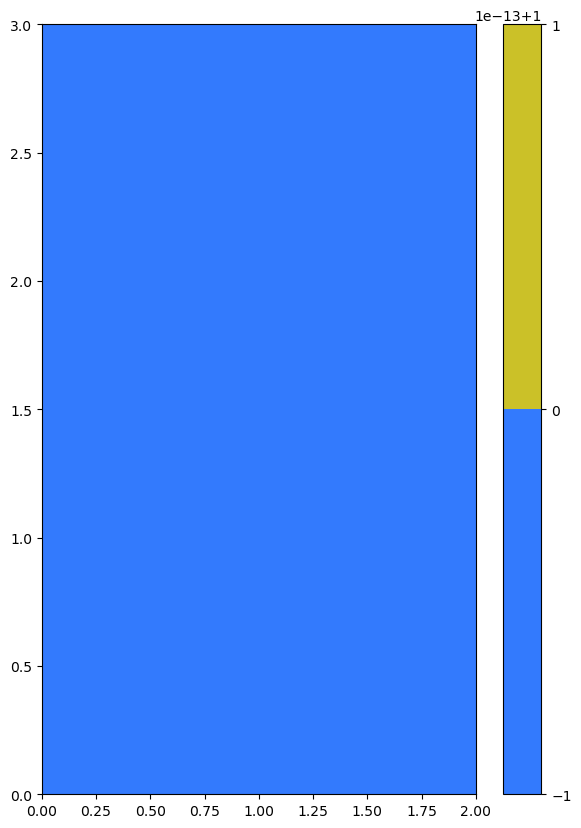

In [30]:
# solve the problem

sol = [initial_solution]

t = 0

save_step(sol[-1], 0)

In [31]:
csv_base = os.path.join(output_directory, 'csv')

if os.path.exists(csv_base):
    shutil.rmtree(csv_base)
    
os.mkdir(csv_base)

In [32]:
glob_mass = global_mass()
top_mass = glob_mass[top_mask, :][:, top_mask]
bottom_mass = glob_mass[bottom_mask, :][:, bottom_mask]

Time 0.02083


Iteration #00001, error L2 relative psi:    0.227744380


<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in power
  return select([less(h, z),True], [0.265*(0.1699265174169*(-h + z)**2.06 + 1)**(-0.514563106796116) + 0.131,0.396], default=nan)


Iteration #00002, error L2 relative psi:    0.068553357
Iteration #00003, error L2 relative psi:    0.010111915
Iteration #00004, error L2 relative psi:    0.000670963
Iteration #00005, error L2 relative psi:    0.000123590
Iteration #00006, error L2 relative psi:    0.000017919
Iteration #00007, error L2 relative psi:    0.000001472


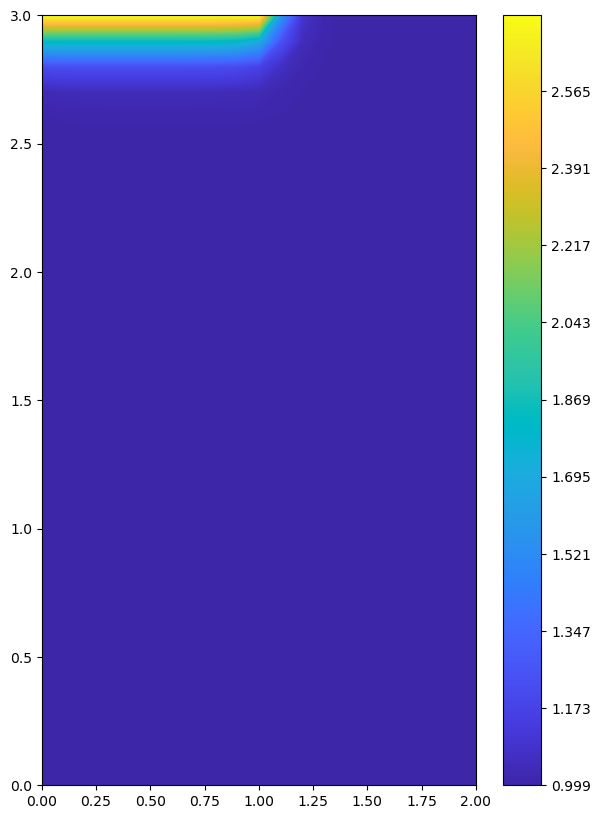


Time 0.04167
Iteration #00001, error L2 relative psi:    0.273037865


<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in scalar power
  return select([less(h, z),True], [0.0496*(1 - (1 - 1.0*(0.1699265174169*(-h + z)**2.06 + 1)**(-1.0))**0.514563106796116)**2*(0.1699265174169*(-h + z)**2.06 + 1)**(-0.257281553398058),0.0496], default=nan)


Iteration #00002, error L2 relative psi:    0.087372669
Iteration #00003, error L2 relative psi:    0.028817238
Iteration #00004, error L2 relative psi:    0.006501493
Iteration #00005, error L2 relative psi:    0.002422278
Iteration #00006, error L2 relative psi:    0.000746288
Iteration #00007, error L2 relative psi:    0.000170078
Iteration #00008, error L2 relative psi:    0.000060465
Iteration #00009, error L2 relative psi:    0.000015607
Iteration #00010, error L2 relative psi:    0.000004512


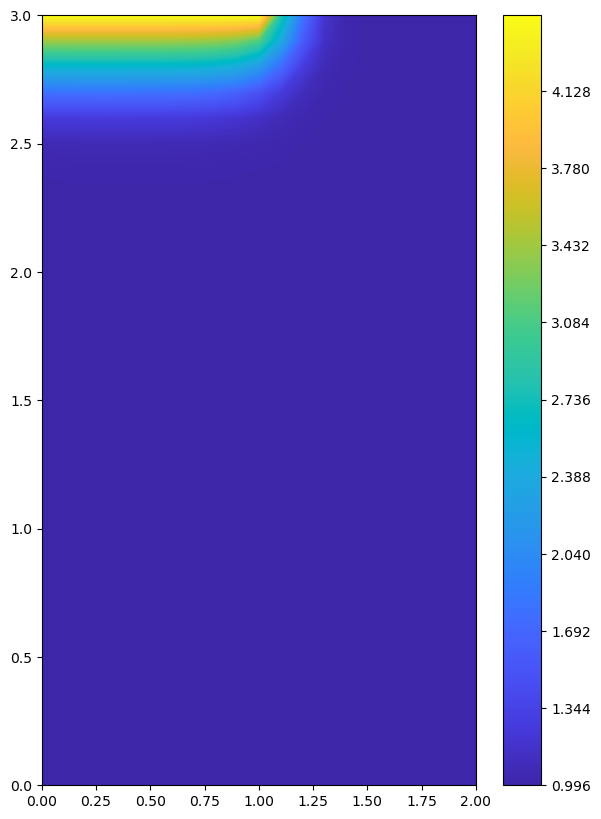


Time 0.0625
Iteration #00001, error L2 relative psi:    0.278530193
Iteration #00002, error L2 relative psi:    0.068260616
Iteration #00003, error L2 relative psi:    0.024997817
Iteration #00004, error L2 relative psi:    0.007840574
Iteration #00005, error L2 relative psi:    0.002163020
Iteration #00006, error L2 relative psi:    0.000653604
Iteration #00007, error L2 relative psi:    0.000279430
Iteration #00008, error L2 relative psi:    0.000126462
Iteration #00009, error L2 relative psi:    0.000053674
Iteration #00010, error L2 relative psi:    0.000021668
Iteration #00011, error L2 relative psi:    0.000008697


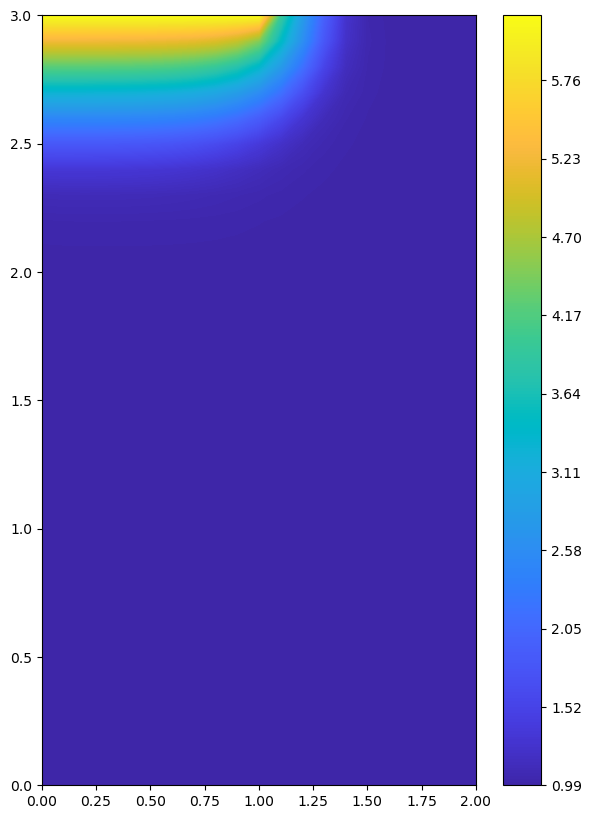


Time 0.08333
Iteration #00001, error L2 relative psi:    0.090510669
Iteration #00002, error L2 relative psi:    0.033271540
Iteration #00003, error L2 relative psi:    0.014921402
Iteration #00004, error L2 relative psi:    0.007338883
Iteration #00005, error L2 relative psi:    0.003990235
Iteration #00006, error L2 relative psi:    0.002301480
Iteration #00007, error L2 relative psi:    0.001350365
Iteration #00008, error L2 relative psi:    0.000793889
Iteration #00009, error L2 relative psi:    0.000466836
Iteration #00010, error L2 relative psi:    0.000274661
Iteration #00011, error L2 relative psi:    0.000161656
Iteration #00012, error L2 relative psi:    0.000095155
Iteration #00013, error L2 relative psi:    0.000056017
Iteration #00014, error L2 relative psi:    0.000032983
Iteration #00015, error L2 relative psi:    0.000019423
Iteration #00016, error L2 relative psi:    0.000011438
Iteration #00017, error L2 relative psi:    0.000006736


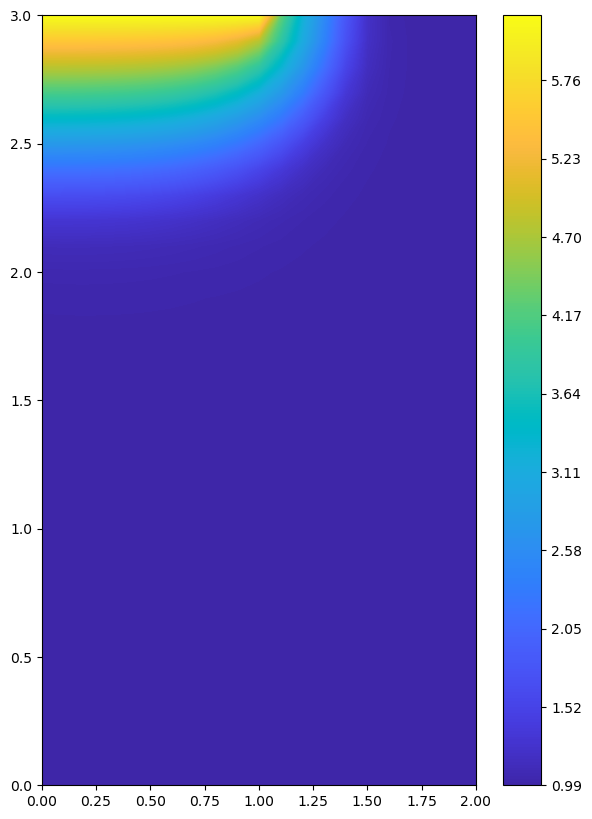


Time 0.10417
Iteration #00001, error L2 relative psi:    0.059980921
Iteration #00002, error L2 relative psi:    0.021795396
Iteration #00003, error L2 relative psi:    0.011397560
Iteration #00004, error L2 relative psi:    0.006976821
Iteration #00005, error L2 relative psi:    0.004605203
Iteration #00006, error L2 relative psi:    0.003131341
Iteration #00007, error L2 relative psi:    0.002153066
Iteration #00008, error L2 relative psi:    0.001487438
Iteration #00009, error L2 relative psi:    0.001030454
Iteration #00010, error L2 relative psi:    0.000715047
Iteration #00011, error L2 relative psi:    0.000496635
Iteration #00012, error L2 relative psi:    0.000345103
Iteration #00013, error L2 relative psi:    0.000239868
Iteration #00014, error L2 relative psi:    0.000166752
Iteration #00015, error L2 relative psi:    0.000115953
Iteration #00016, error L2 relative psi:    0.000080643
Iteration #00017, error L2 relative psi:    0.000056090
Iteration #00018, error L2 relativ

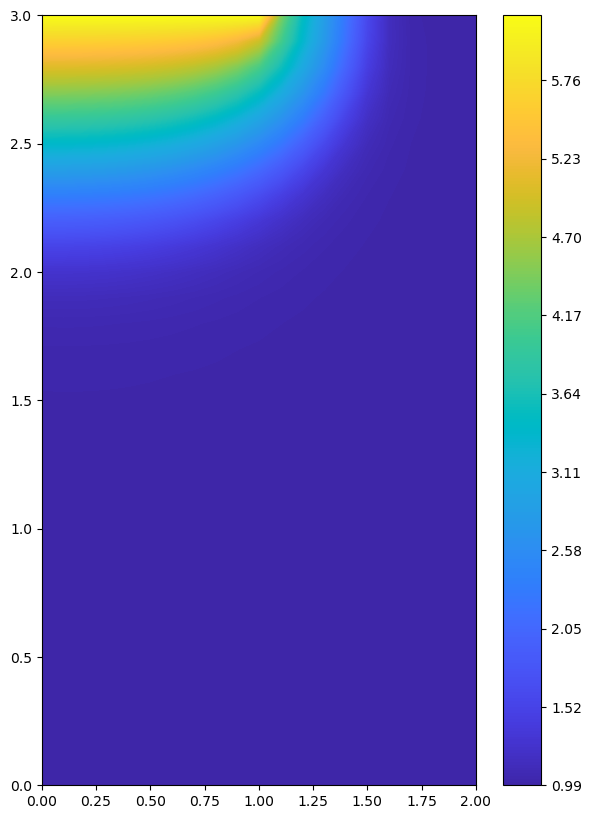


Time 0.125
Iteration #00001, error L2 relative psi:    0.044665914
Iteration #00002, error L2 relative psi:    0.016470357
Iteration #00003, error L2 relative psi:    0.009545033
Iteration #00004, error L2 relative psi:    0.006486051
Iteration #00005, error L2 relative psi:    0.004704423
Iteration #00006, error L2 relative psi:    0.003503140
Iteration #00007, error L2 relative psi:    0.002640589
Iteration #00008, error L2 relative psi:    0.002003208
Iteration #00009, error L2 relative psi:    0.001525402
Iteration #00010, error L2 relative psi:    0.001164164
Iteration #00011, error L2 relative psi:    0.000889634
Iteration #00012, error L2 relative psi:    0.000680477
Iteration #00013, error L2 relative psi:    0.000520929
Iteration #00014, error L2 relative psi:    0.000398998
Iteration #00015, error L2 relative psi:    0.000305708
Iteration #00016, error L2 relative psi:    0.000234276
Iteration #00017, error L2 relative psi:    0.000179569
Iteration #00018, error L2 relative 

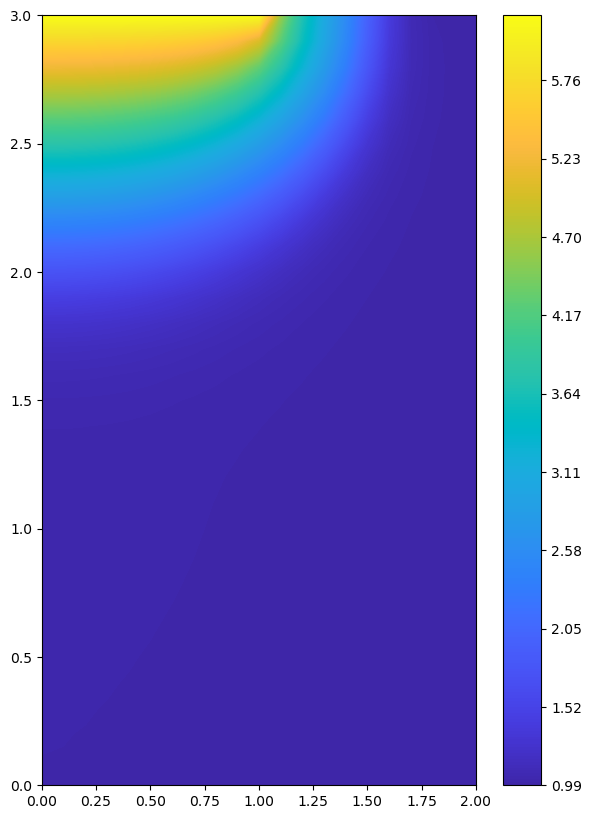


Time 0.14583
Iteration #00001, error L2 relative psi:    0.035102941
Iteration #00002, error L2 relative psi:    0.013692121
Iteration #00003, error L2 relative psi:    0.008670707
Iteration #00004, error L2 relative psi:    0.006342988
Iteration #00005, error L2 relative psi:    0.004927259
Iteration #00006, error L2 relative psi:    0.003932333
Iteration #00007, error L2 relative psi:    0.003181536
Iteration #00008, error L2 relative psi:    0.002593382
Iteration #00009, error L2 relative psi:    0.002123508
Iteration #00010, error L2 relative psi:    0.001743587
Iteration #00011, error L2 relative psi:    0.001434644
Iteration #00012, error L2 relative psi:    0.001182359
Iteration #00013, error L2 relative psi:    0.000975665
Iteration #00014, error L2 relative psi:    0.000805850
Iteration #00015, error L2 relative psi:    0.000666085
Iteration #00016, error L2 relative psi:    0.000550879
Iteration #00017, error L2 relative psi:    0.000455815
Iteration #00018, error L2 relativ

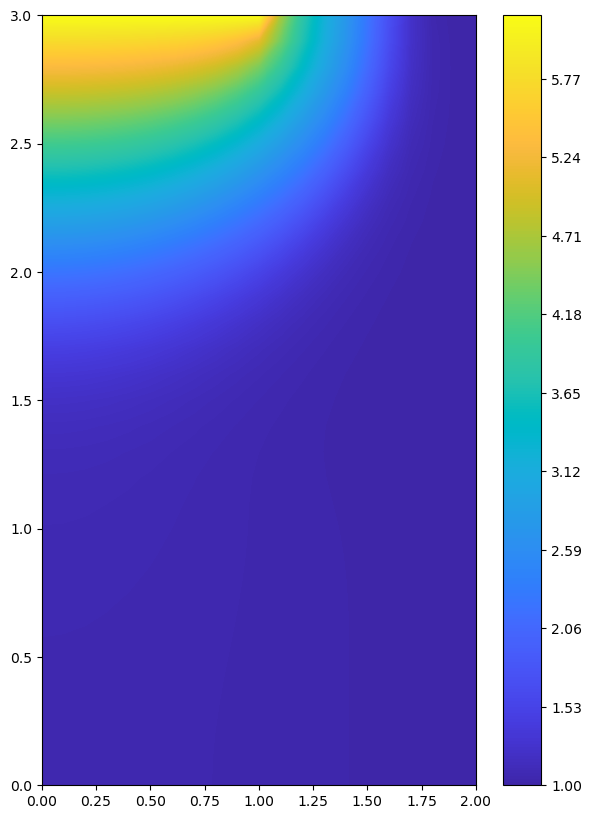


Time 0.16667
Iteration #00001, error L2 relative psi:    0.028388624
Iteration #00002, error L2 relative psi:    0.012325482
Iteration #00003, error L2 relative psi:    0.009141093
Iteration #00004, error L2 relative psi:    0.007661240
Iteration #00005, error L2 relative psi:    0.006733472
Iteration #00006, error L2 relative psi:    0.006042469
Iteration #00007, error L2 relative psi:    0.005479558
Iteration #00008, error L2 relative psi:    0.004996040
Iteration #00009, error L2 relative psi:    0.004567827
Iteration #00010, error L2 relative psi:    0.004184451
Iteration #00011, error L2 relative psi:    0.003839838
Iteration #00012, error L2 relative psi:    0.003529012
Iteration #00013, error L2 relative psi:    0.003247875
Iteration #00014, error L2 relative psi:    0.002992496
Iteration #00015, error L2 relative psi:    0.002759819
Iteration #00016, error L2 relative psi:    0.002547423
Iteration #00017, error L2 relative psi:    0.002353169
Iteration #00018, error L2 relativ

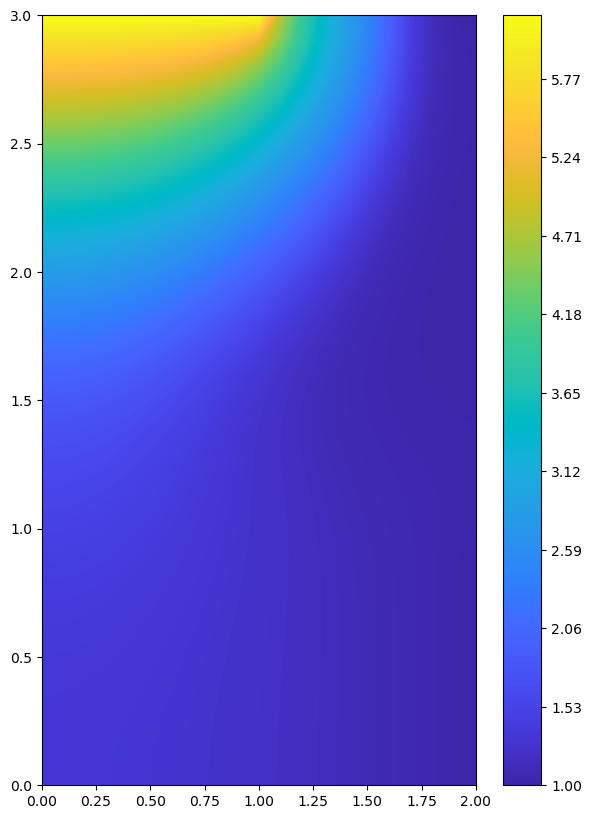


Time 0.1875
Iteration #00001, error L2 relative psi:    0.022861044
Iteration #00002, error L2 relative psi:    0.010243204
Iteration #00003, error L2 relative psi:    0.008439894
Iteration #00004, error L2 relative psi:    0.007657251
Iteration #00005, error L2 relative psi:    0.007126635
Iteration #00006, error L2 relative psi:    0.006679383
Iteration #00007, error L2 relative psi:    0.006272617
Iteration #00008, error L2 relative psi:    0.005893477
Iteration #00009, error L2 relative psi:    0.005538100
Iteration #00010, error L2 relative psi:    0.005205007
Iteration #00011, error L2 relative psi:    0.004892978
Iteration #00012, error L2 relative psi:    0.004600782
Iteration #00013, error L2 relative psi:    0.004327246
Iteration #00014, error L2 relative psi:    0.004071179
Iteration #00015, error L2 relative psi:    0.003831421
Iteration #00016, error L2 relative psi:    0.003606885
Iteration #00017, error L2 relative psi:    0.003396502
Iteration #00018, error L2 relative

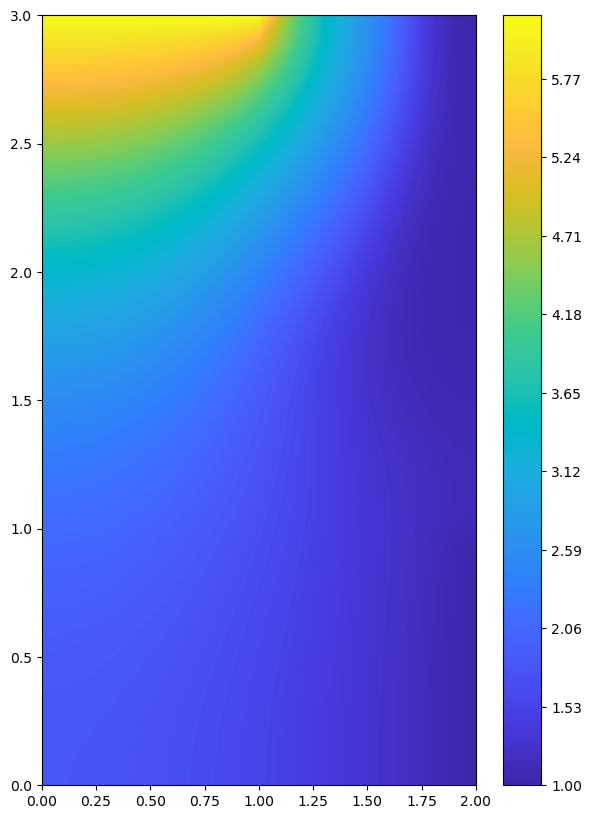


Time 0.20833
Iteration #00001, error L2 relative psi:    0.019307668
Iteration #00002, error L2 relative psi:    0.007194259
Iteration #00003, error L2 relative psi:    0.005139723
Iteration #00004, error L2 relative psi:    0.004199432
Iteration #00005, error L2 relative psi:    0.003642293
Iteration #00006, error L2 relative psi:    0.003257740
Iteration #00007, error L2 relative psi:    0.002969429
Iteration #00008, error L2 relative psi:    0.002740755
Iteration #00009, error L2 relative psi:    0.002551772
Iteration #00010, error L2 relative psi:    0.002390467
Iteration #00011, error L2 relative psi:    0.002249158
Iteration #00012, error L2 relative psi:    0.002122738
Iteration #00013, error L2 relative psi:    0.002007772
Iteration #00014, error L2 relative psi:    0.001901961
Iteration #00015, error L2 relative psi:    0.001803687
Iteration #00016, error L2 relative psi:    0.001711796
Iteration #00017, error L2 relative psi:    0.001625469
Iteration #00018, error L2 relativ

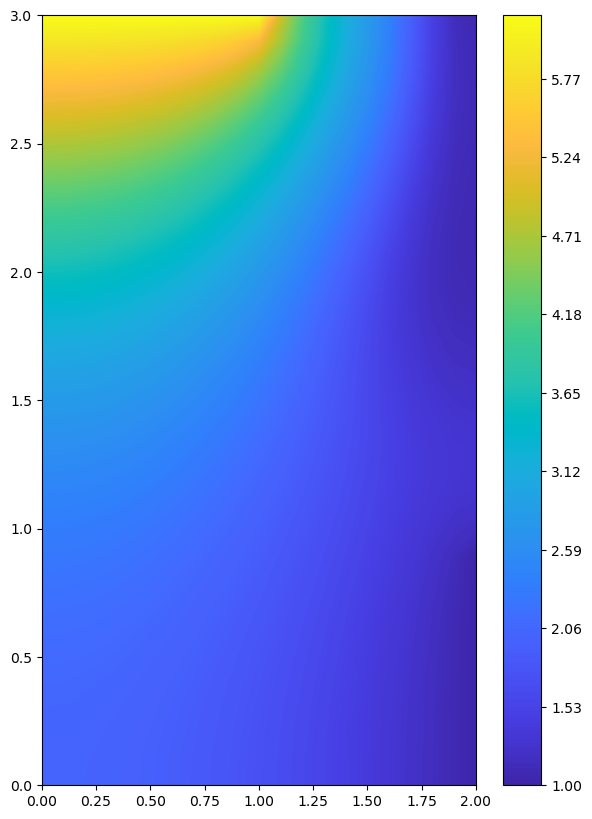


Time 0.22917
Iteration #00001, error L2 relative psi:    0.017745486
Iteration #00002, error L2 relative psi:    0.005789705
Iteration #00003, error L2 relative psi:    0.003936402
Iteration #00004, error L2 relative psi:    0.003102918
Iteration #00005, error L2 relative psi:    0.002621345
Iteration #00006, error L2 relative psi:    0.002296643
Iteration #00007, error L2 relative psi:    0.002058628
Iteration #00008, error L2 relative psi:    0.001874791
Iteration #00009, error L2 relative psi:    0.001727533
Iteration #00010, error L2 relative psi:    0.001606093
Iteration #00011, error L2 relative psi:    0.001503435
Iteration #00012, error L2 relative psi:    0.001414743
Iteration #00013, error L2 relative psi:    0.001336628
Iteration #00014, error L2 relative psi:    0.001266652
Iteration #00015, error L2 relative psi:    0.001203079
Iteration #00016, error L2 relative psi:    0.001144642
Iteration #00017, error L2 relative psi:    0.001090413
Iteration #00018, error L2 relativ

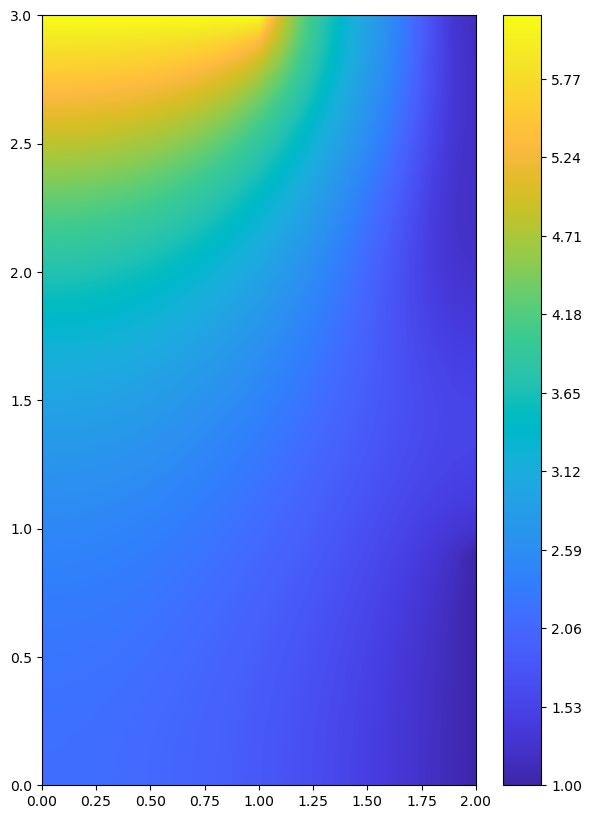


Time 0.25
Iteration #00001, error L2 relative psi:    0.017537686
Iteration #00002, error L2 relative psi:    0.005618344
Iteration #00003, error L2 relative psi:    0.003806363
Iteration #00004, error L2 relative psi:    0.002996727
Iteration #00005, error L2 relative psi:    0.002523849
Iteration #00006, error L2 relative psi:    0.002205435
Iteration #00007, error L2 relative psi:    0.001971875
Iteration #00008, error L2 relative psi:    0.001791127
Iteration #00009, error L2 relative psi:    0.001646139
Iteration #00010, error L2 relative psi:    0.001526651
Iteration #00011, error L2 relative psi:    0.001426040
Iteration #00012, error L2 relative psi:    0.001339789
Iteration #00013, error L2 relative psi:    0.001264647
Iteration #00014, error L2 relative psi:    0.001198203
Iteration #00015, error L2 relative psi:    0.001138657
Iteration #00016, error L2 relative psi:    0.001084659
Iteration #00017, error L2 relative psi:    0.001035171
Iteration #00018, error L2 relative p

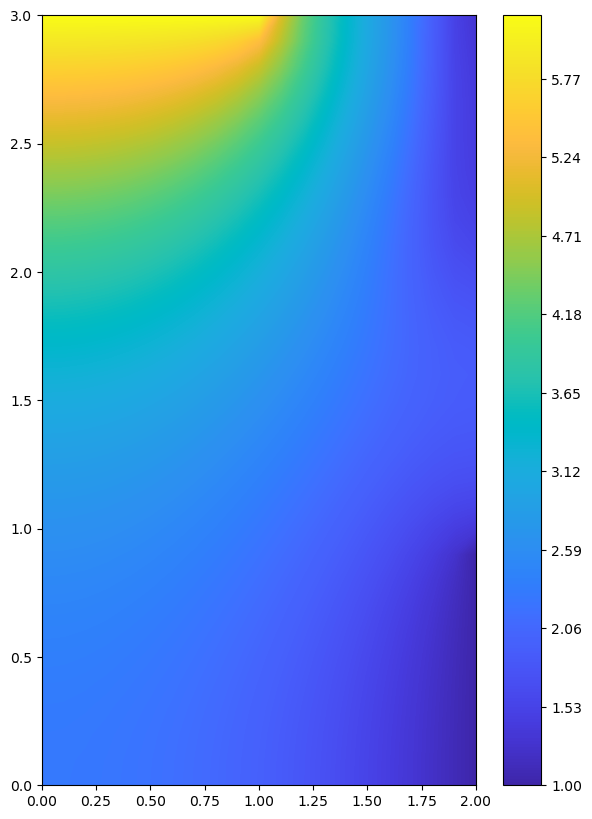


Time 0.27083
Iteration #00001, error L2 relative psi:    0.017442438
Iteration #00002, error L2 relative psi:    0.006321194
Iteration #00003, error L2 relative psi:    0.004373176
Iteration #00004, error L2 relative psi:    0.003489139
Iteration #00005, error L2 relative psi:    0.002956782
Iteration #00006, error L2 relative psi:    0.002589614
Iteration #00007, error L2 relative psi:    0.002317504
Iteration #00008, error L2 relative psi:    0.002106237
Iteration #00009, error L2 relative psi:    0.001936498
Iteration #00010, error L2 relative psi:    0.001796541
Iteration #00011, error L2 relative psi:    0.001678837
Iteration #00012, error L2 relative psi:    0.001578105
Iteration #00013, error L2 relative psi:    0.001490709
Iteration #00014, error L2 relative psi:    0.001413893
Iteration #00015, error L2 relative psi:    0.001345556
Iteration #00016, error L2 relative psi:    0.001284108
Iteration #00017, error L2 relative psi:    0.001228283
Iteration #00018, error L2 relativ

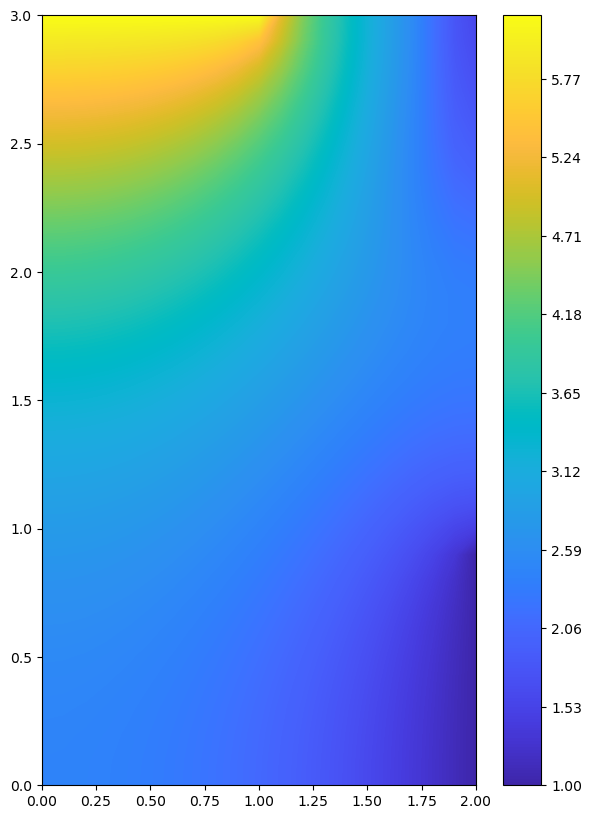


Time 0.29167
Iteration #00001, error L2 relative psi:    0.016290096
Iteration #00002, error L2 relative psi:    0.007226112
Iteration #00003, error L2 relative psi:    0.005186411
Iteration #00004, error L2 relative psi:    0.004215715
Iteration #00005, error L2 relative psi:    0.003608905
Iteration #00006, error L2 relative psi:    0.003181014
Iteration #00007, error L2 relative psi:    0.002856365
Iteration #00008, error L2 relative psi:    0.002598722
Iteration #00009, error L2 relative psi:    0.002388238
Iteration #00010, error L2 relative psi:    0.002213032
Iteration #00011, error L2 relative psi:    0.002064860
Iteration #00012, error L2 relative psi:    0.001937948
Iteration #00013, error L2 relative psi:    0.001828041
Iteration #00014, error L2 relative psi:    0.001731928
Iteration #00015, error L2 relative psi:    0.001647047
Iteration #00016, error L2 relative psi:    0.001571428
Iteration #00017, error L2 relative psi:    0.001503492
Iteration #00018, error L2 relativ

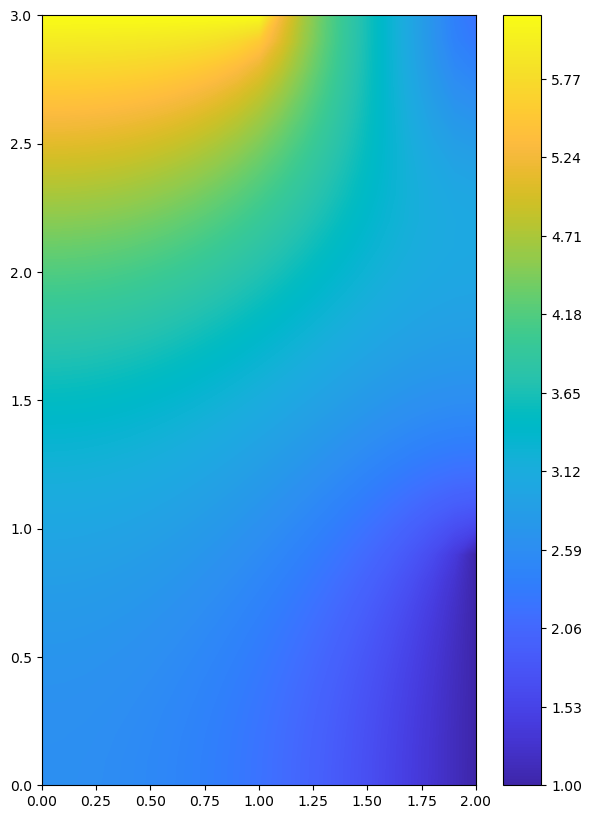


Time 0.3125
Iteration #00001, error L2 relative psi:    0.013607939
Iteration #00002, error L2 relative psi:    0.008556561
Iteration #00003, error L2 relative psi:    0.006917743
Iteration #00004, error L2 relative psi:    0.005997235
Iteration #00005, error L2 relative psi:    0.005346730
Iteration #00006, error L2 relative psi:    0.004840612
Iteration #00007, error L2 relative psi:    0.004429127
Iteration #00008, error L2 relative psi:    0.004085037
Iteration #00009, error L2 relative psi:    0.003791537
Iteration #00010, error L2 relative psi:    0.003537530
Iteration #00011, error L2 relative psi:    0.003315279
Iteration #00012, error L2 relative psi:    0.003119145
Iteration #00013, error L2 relative psi:    0.002944859
Iteration #00014, error L2 relative psi:    0.002789087
Iteration #00015, error L2 relative psi:    0.002649159
Iteration #00016, error L2 relative psi:    0.002522888
Iteration #00017, error L2 relative psi:    0.002408454
Iteration #00018, error L2 relative

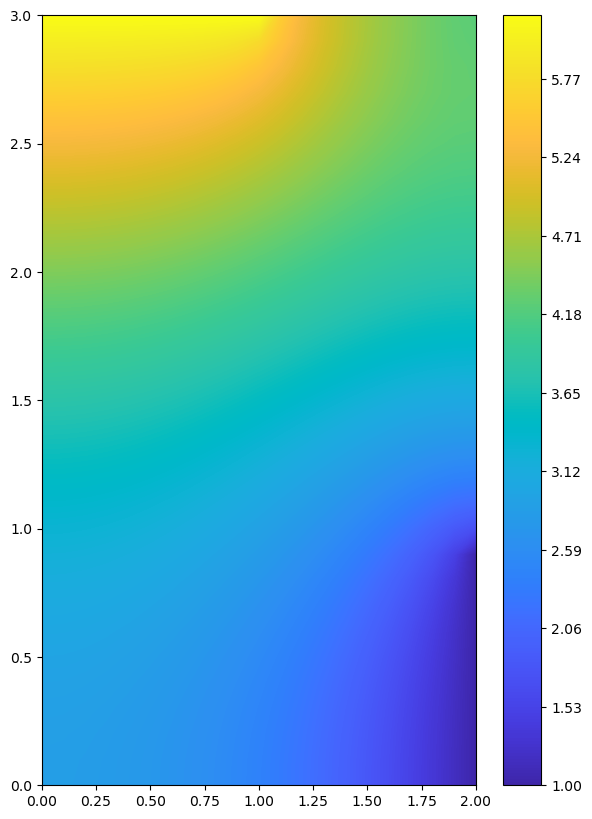


Time 0.33333
Iteration #00001, error L2 relative psi:    0.002241016
Iteration #00002, error L2 relative psi:    0.001442408
Iteration #00003, error L2 relative psi:    0.001114628
Iteration #00004, error L2 relative psi:    0.000931965
Iteration #00005, error L2 relative psi:    0.000811553
Iteration #00006, error L2 relative psi:    0.000723809
Iteration #00007, error L2 relative psi:    0.000655682
Iteration #00008, error L2 relative psi:    0.000600516
Iteration #00009, error L2 relative psi:    0.000554539
Iteration #00010, error L2 relative psi:    0.000515428
Iteration #00011, error L2 relative psi:    0.000481654
Iteration #00012, error L2 relative psi:    0.000452153
Iteration #00013, error L2 relative psi:    0.000426154
Iteration #00014, error L2 relative psi:    0.000403076
Iteration #00015, error L2 relative psi:    0.000382465
Iteration #00016, error L2 relative psi:    0.000363960
Iteration #00017, error L2 relative psi:    0.000347265
Iteration #00018, error L2 relativ

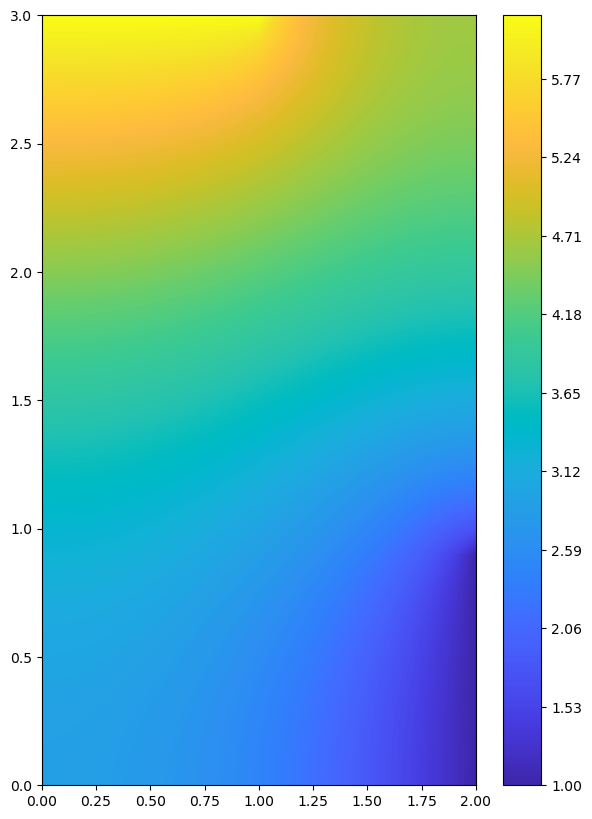


Time 0.35417
Iteration #00001, error L2 relative psi:    0.000009700


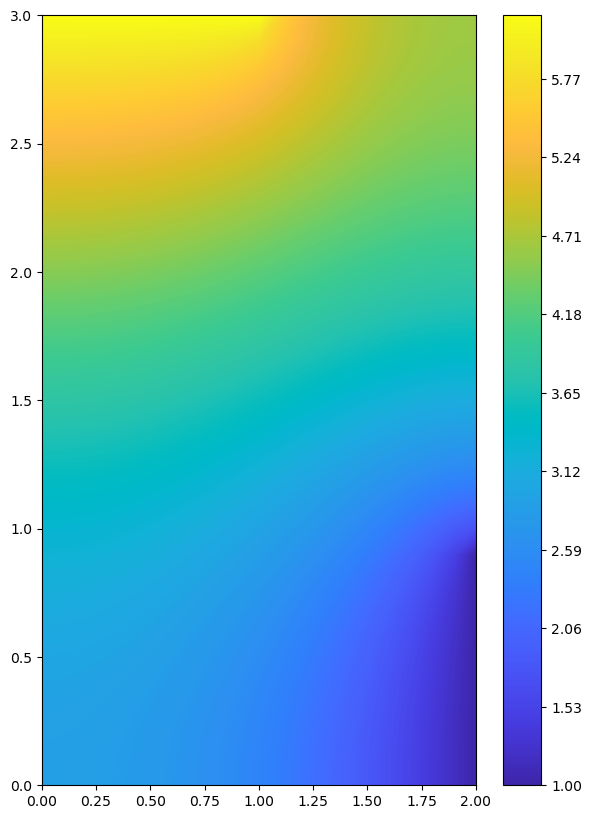


Time 0.375
Iteration #00001, error L2 relative psi:    0.000009458


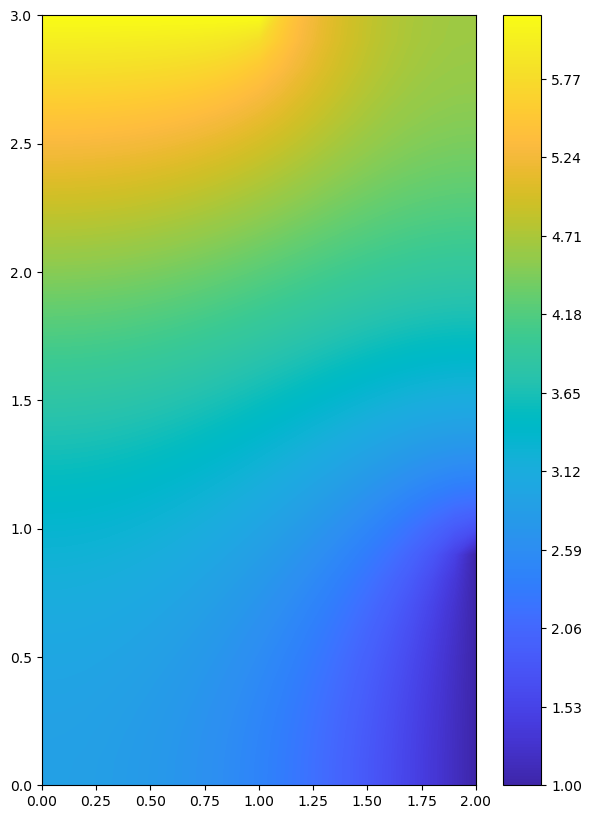


Time 0.39583
Iteration #00001, error L2 relative psi:    0.000009223


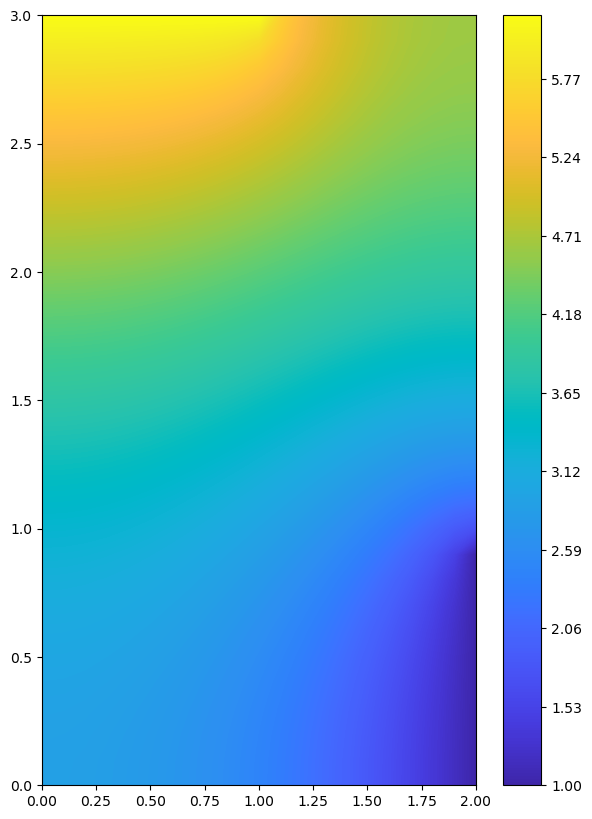


Time 0.41667
Iteration #00001, error L2 relative psi:    0.000008993


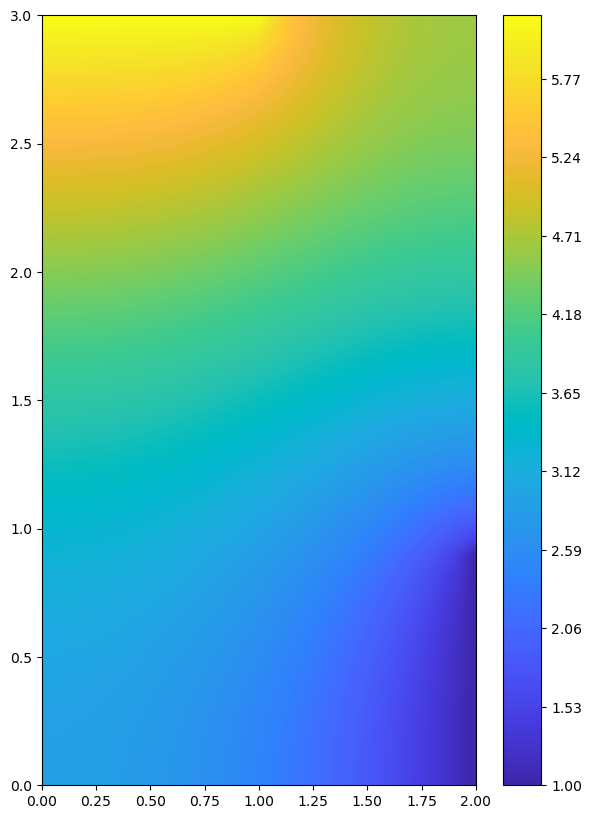


Time 0.4375
Iteration #00001, error L2 relative psi:    0.000008769


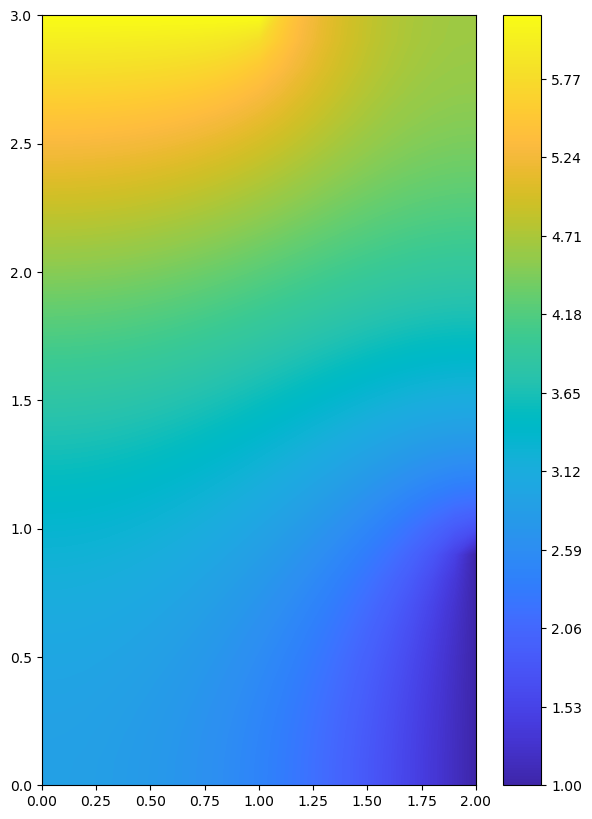


Time 0.45833
Iteration #00001, error L2 relative psi:    0.000008551


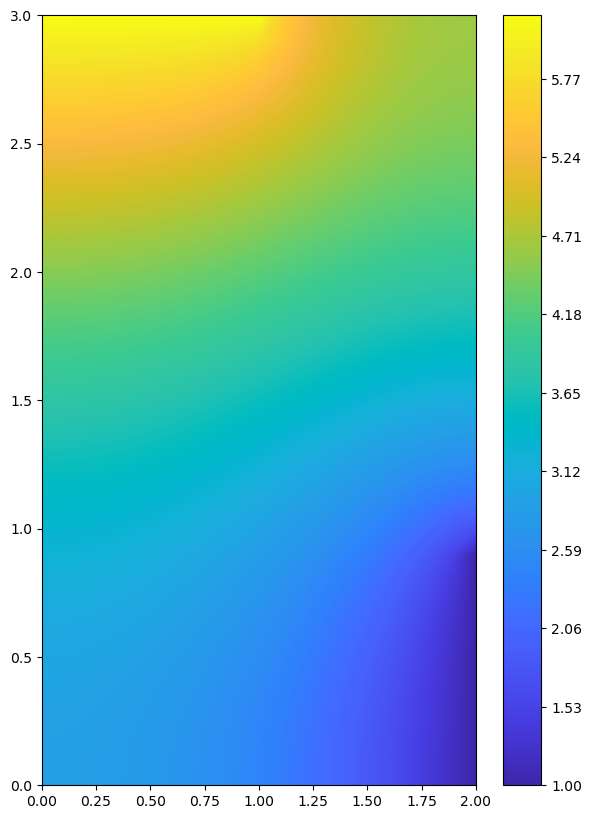


Time 0.47917
Iteration #00001, error L2 relative psi:    0.000008338


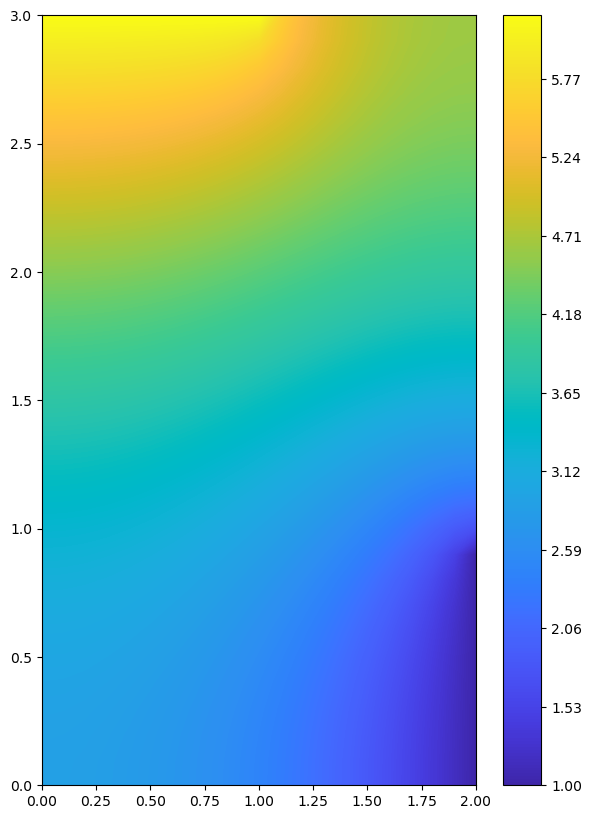


Time 0.5
Iteration #00001, error L2 relative psi:    0.000008131


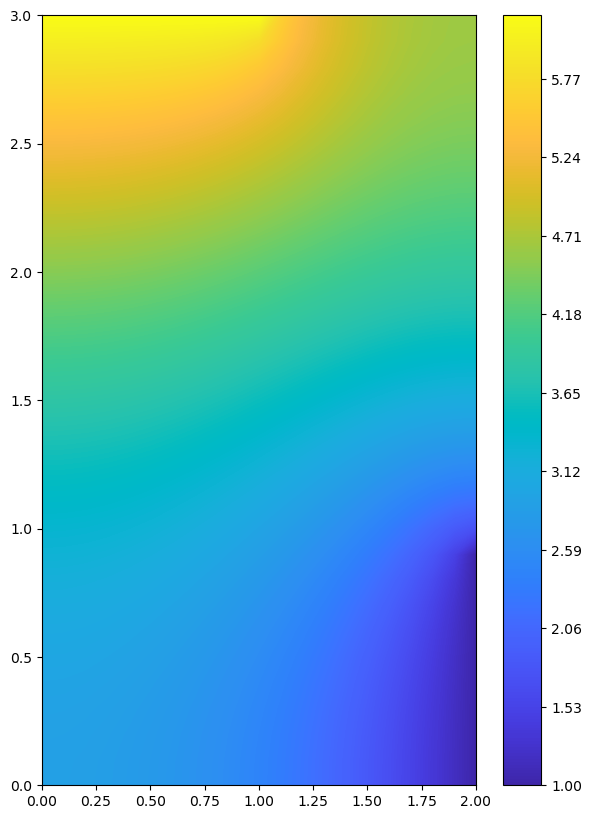


Time 0.52083
Iteration #00001, error L2 relative psi:    0.000007928


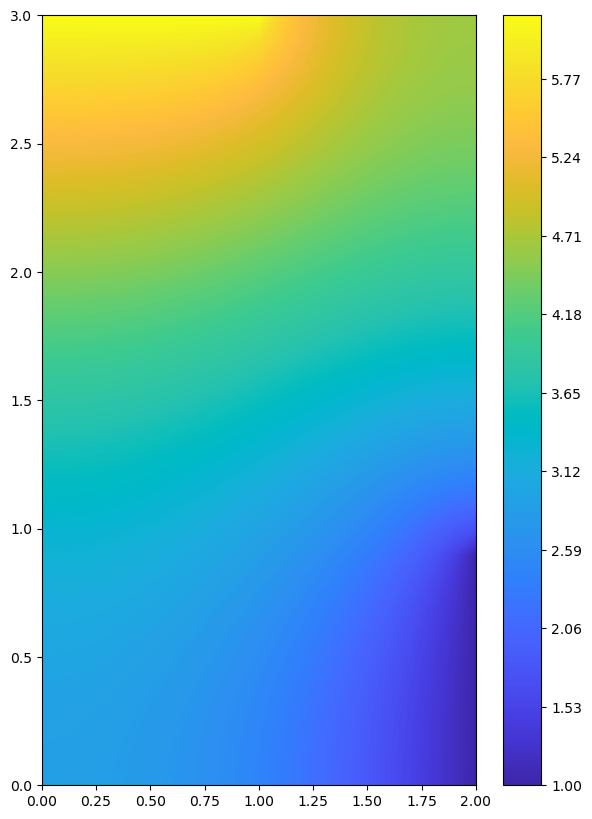


Time 0.54167
Iteration #00001, error L2 relative psi:    0.000007731


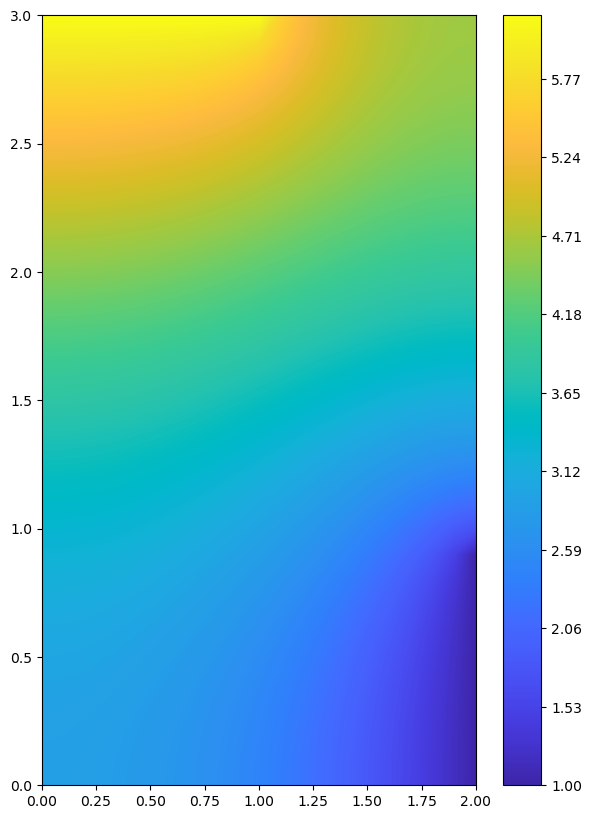


Time 0.5625
Iteration #00001, error L2 relative psi:    0.000007539


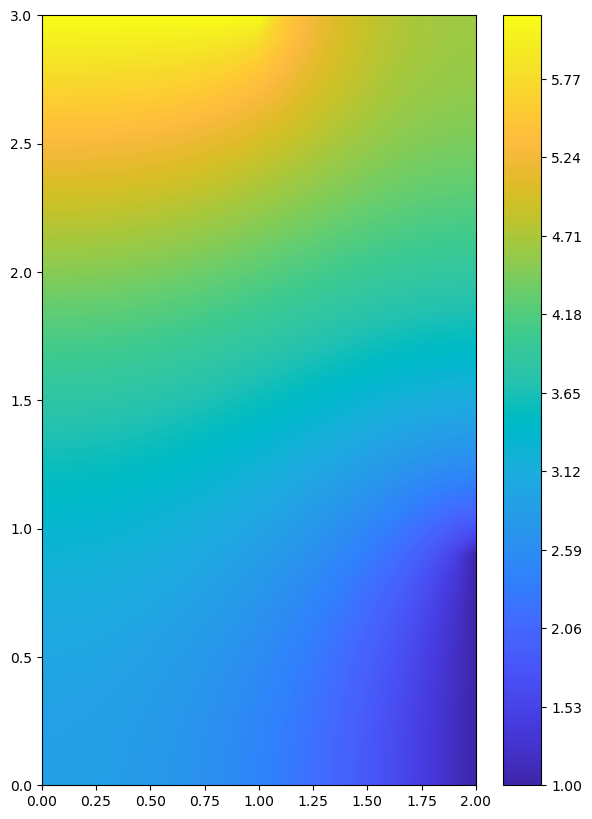

In [33]:
# Time Loop
for step in range(1, ceil(T/dt) + 1):
    current_time = step * dt
    print('Time ' + str(round(current_time, 5)))
    
    time_rhs = np.zeros_like(sol[-1])

    time_rhs[top_mask] += top_mass @ model_data.theta(sol[-1][top_mask], 1 + top_grid.nodes[1,:]) / dt

    prev = sol[-1]

    for k in range(K):
        rhs = time_rhs.copy()

        rhs[top_mask] += L * top_mass @ prev[top_mask] / dt
        rhs[top_mask] -= top_mass @ model_data.theta(prev[top_mask], 1 + top_grid.nodes[1,:]) / dt

        global_stif = global_stifness( prev[top_mask] )

        bottom_mat = global_stif[bottom_mask, :][:, bottom_mask]
        top_mat    = global_stif[top_mask, :][:, top_mask] + L / dt * top_mass
        mid_mat = global_stif[boundary_mask, :][:, boundary_mask] + L / dt * glob_mass[boundary_mask, :][:, boundary_mask]
        
        spp = sps.bmat([[    bottom_delete_boundary_dof @ bottom_mat @ bottom_delete_boundary_dof.T, bottom_delete_boundary_dof @ bottom_mat @ bottom_isolate_boundary_dof.T,                                                             None],
                        [ bottom_isolate_boundary_dof @ bottom_mat.T @ bottom_delete_boundary_dof.T,                                                                 mid_mat, top_isolate_boundary_dof @ top_mat.T @ top_delete_boundary_dof.T],
                        [                                                                      None,          top_delete_boundary_dof @ top_mat @ top_isolate_boundary_dof.T,    top_delete_boundary_dof @ top_mat @ top_delete_boundary_dof.T]], format = 'csc')
        
        ls = pg.LinearSystem(spp, rhs)

        #print(spp, rhs)

        ls.flag_ess_bc(dirichlet_flag, dirichlet_value(current_time))

        current = ls.solve()

        # Check if we have reached convergence
        rel_err_psi  = np.sqrt( (current - prev).T @ (current - prev) )
        abs_err_prev = np.sqrt( prev.T @ prev )

        # Log message with error and current iteration
        print('Iteration #' + format(k+1, '0' + str(ceil(log10(K)) + 1) + 'd') + ', error L2 relative psi: ' 
              + format(rel_err_psi / abs_err_prev, str(5 + ceil(log10(1 / abs_tol)) + 4) + '.' + str(ceil(log10(1 / abs_tol)) + 4) + 'f') )
        
        if rel_err_psi > abs_tol + rel_tol * abs_err_prev:
            prev = current.copy()
        else:
            break

    sol.append( current )

    save_step(sol[-1], step)
    print('')    